# NLP: Sentiment analysis on Movie Reviews (v1)

ML Sample of Natural Language Processing.

- For environment test and confirmation.

## Dataset

Sentiment Analysis on Movie Reviews
> Classify the sentiment of sentences from the Rotten Tomatoes dataset

https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import contractions 
import re
from nltk.corpus import stopwords
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score


In [2]:
pd.set_option("display.max_colwidth", 140)

nltk.download('stopwords')

STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load Train Dataset
df_train = pd.read_csv(
    "./raw_data/train.tsv",
    delimiter="\t",
    na_filter=False
)

display(df_train)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally a...",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


## Methods preparation

In [4]:
def clean_text(text: str) -> str:
    """Clean text."""
    text = _clean_text_html_tag_removing(text)
    text = _clean_text_expand_contractions(text)
    text = _clean_text_lowercase_conversion(text)
    text = _clean_text_non_alpha_numeric_replacing(text)
    text = _clean_text_stopwords_removing(text)
    return text
    

def _clean_text_html_tag_removing(text: str) -> str:
    """Clean text with removing HTML tags."""
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


def _clean_text_expand_contractions(text: str) -> str:
    """Clean text with expansion contractions."""
    return contractions.fix(text)


def _clean_text_lowercase_conversion(text: str) -> str:
    """Clean text with lower case conversion."""
    return text.lower()


def _clean_text_non_alpha_numeric_replacing(text: str) -> str:
    """Clean text by replacing non-alphanumeric characters with spaces."""
    return re.sub("[^a-zA-Z0-9]", " ", text)


def _clean_text_stopwords_removing(text: str) -> str:
    """Clean text with removing stopwords."""
    words = text.split()
    words = [
        word for word in words if word not in STOPWORDS
    ]
    return ' '.join(words)


def evaluate_trained_model(
    model: BaseEstimator,
    X_val_data: list,
    y_val_data: list
) -> None:
    """Evaluate a trained Machine Learning model using various metrics

    This function provides:
    - Accuracy Score: Measures how accurately the class labels are predicted.
    - Precision Score: Evaluates how many of the items predicted as positive are actually positive.
    - Confusion Matrix: Provides a matrix representing TP, FP, FN, TN for each class.
    - Classification Report: Generates a detailed report including Precision, Recall, F1-score, and Support for each class.

    Args:
        model: Trained machine learning model.
        X_test_data, y_test_data: Test data and labels.
    """
    y_pred = model.predict(X_val_data)

    print(f"Evaluation: {model.__class__.__name__}\n")  
    print("Accuracy:", accuracy_score(y_val_data, y_pred))
    print("Precision (macro):", precision_score(
        y_val_data,
        y_pred,
        average='macro'
    ))
    print("Confusion Matrix:\n", confusion_matrix(y_val_data, y_pred))
    print("Classification Report:\n", classification_report(
        y_val_data,
        y_pred,
        zero_division=1
    ))

## Check train data details

In [5]:
df_train_sentiment_values = df_train['Sentiment'].value_counts().sort_index()

print(df_train_sentiment_values)

0     7072
1    27273
2    79582
3    32927
4     9206
Name: Sentiment, dtype: int64


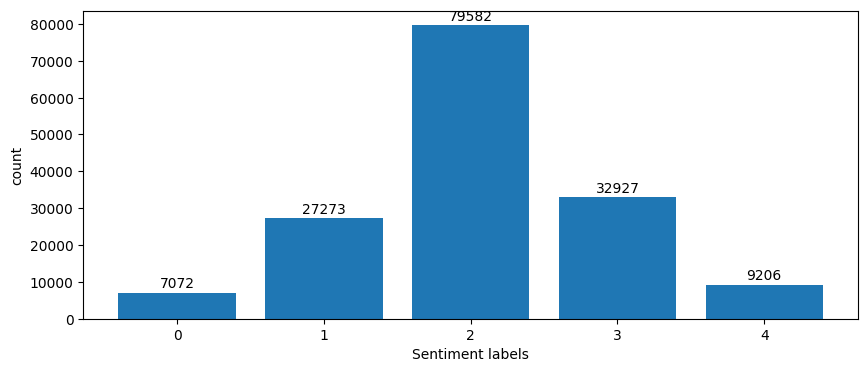

In [6]:
# Plot Sentiment labels Distribution in Training Set
fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(
    df_train_sentiment_values.index,
    df_train_sentiment_values.values,
    label='Sentiment label'
)

# add a value to each bar as an annotation
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 500,
        int(height), 
        ha='center',
        va='bottom',
        fontsize=10
    )

ax.set_xlabel('Sentiment labels')
ax.set_ylabel('count')
plt.show()

## Data Preprocessing

In [7]:
# Clean text
df_train['Phrase'] = df_train['Phrase'].apply(clean_text)

display(df_train.head(10))
print(df_train.shape)

/tmp/ipykernel_1008/4262371111.py:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,series escapades demonstrating adage good goose also good gander occasionally amuses none amounts much story,1
1,2,1,series escapades demonstrating adage good goose,2
2,3,1,series,2
3,4,1,,2
4,5,1,series,2
5,6,1,escapades demonstrating adage good goose,2
6,7,1,,2
7,8,1,escapades demonstrating adage good goose,2
8,9,1,escapades,2
9,10,1,demonstrating adage good goose,2


(156060, 4)


In [8]:
# For model building, drop Phrase empty rows.
df_train['Phrase'].replace(
    '',
    np.nan,
    inplace =True
)
df_train.dropna(
    subset=['Phrase'],
    inplace =True
)

display(df_train.head(10))
print(df_train.shape)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,series escapades demonstrating adage good goose also good gander occasionally amuses none amounts much story,1
1,2,1,series escapades demonstrating adage good goose,2
2,3,1,series,2
4,5,1,series,2
5,6,1,escapades demonstrating adage good goose,2
7,8,1,escapades demonstrating adage good goose,2
8,9,1,escapades,2
9,10,1,demonstrating adage good goose,2
10,11,1,demonstrating adage,2
11,12,1,demonstrating,2


(154866, 4)


In [9]:
# (NOT USE) For model building, drop duplicated rows they have same Phrase and Sentiment

# df_train = df_train.drop_duplicates(
#     subset=['Phrase', 'Sentiment'],
#     keep='first'
# )

# display(df_train.head())
# print(df_train.shape)

In [10]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5_000)

X = vectorizer.fit_transform(df_train['Phrase'])
y = df_train['Sentiment']

## Model Building

In [11]:
# split data
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [12]:
# Model Building: Support Vector Machine
model_svm = SVC()
model_svm.fit(X_train, y_train)

# Evaluation
evaluate_trained_model(
    model_svm,
    X_val,
    y_val
)

Evaluation: SVC

Accuracy: 0.6529347194421128
Precision (macro): 0.6033152431304971
Confusion Matrix:
 [[  353   711   314    20     1]
 [  231  2285  2808   162     6]
 [   53   926 13640  1072    34]
 [    4   115  2755  3411   301]
 [    0     7   201  1029   535]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.25      0.35      1399
           1       0.57      0.42      0.48      5492
           2       0.69      0.87      0.77     15725
           3       0.60      0.52      0.56      6586
           4       0.61      0.30      0.40      1772

    accuracy                           0.65     30974
   macro avg       0.60      0.47      0.51     30974
weighted avg       0.64      0.65      0.63     30974



In [17]:
# Model Building: Logistic Regression model and train model
model_lr = LogisticRegression(max_iter=5000)
model_lr.fit(X_train, y_train)

# Evaluation
evaluate_trained_model(
    model_lr,
    X_val,
    y_val
)

Evaluation: LogisticRegression

Accuracy: 0.6224575450377736
Precision (macro): 0.5755888587620902
Confusion Matrix:
 [[  265   608   459    62     5]
 [  169  1768  3208   337    10]
 [   40   793 13755  1083    54]
 [    7   166  3122  3063   228]
 [    0    26   292  1025   429]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.19      0.28      1399
           1       0.53      0.32      0.40      5492
           2       0.66      0.87      0.75     15725
           3       0.55      0.47      0.50      6586
           4       0.59      0.24      0.34      1772

    accuracy                           0.62     30974
   macro avg       0.58      0.42      0.46     30974
weighted avg       0.60      0.62      0.59     30974



In [14]:
# Model Building: Random Forest
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Evaluation
evaluate_trained_model(
    model_rf,
    X_val,
    y_val
)

Evaluation: RandomForestClassifier

Accuracy: 0.6329502163104539
Precision (macro): 0.5482028674742077
Confusion Matrix:
 [[  508   610   251    28     2]
 [  469  2331  2451   228    13]
 [  135  1265 12787  1442    96]
 [   12   160  2526  3249   639]
 [    0    11   182   849   730]]
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.36      0.40      1399
           1       0.53      0.42      0.47      5492
           2       0.70      0.81      0.75     15725
           3       0.56      0.49      0.52      6586
           4       0.49      0.41      0.45      1772

    accuracy                           0.63     30974
   macro avg       0.55      0.50      0.52     30974
weighted avg       0.62      0.63      0.62     30974



In [15]:
# Model Building: Multinomial Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

# Evaluation
evaluate_trained_model(
    model_nb,
    X_val,
    y_val
)

Evaluation: MultinomialNB

Accuracy: 0.5834570930457803
Precision (macro): 0.5892169377029803
Confusion Matrix:
 [[   74   419   863    43     0]
 [   40  1059  4244   148     1]
 [    5   387 14587   737     9]
 [    1    69  4237  2213    66]
 [    0     8   710   915   139]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.05      0.10      1399
           1       0.55      0.19      0.28      5492
           2       0.59      0.93      0.72     15725
           3       0.55      0.34      0.42      6586
           4       0.65      0.08      0.14      1772

    accuracy                           0.58     30974
   macro avg       0.59      0.32      0.33     30974
weighted avg       0.58      0.58      0.52     30974

